In [77]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import statsmodels.api as sm


# w weights Vector, V Cov matrix
def calculate_portfolio_var(w, V):
    w = np.matrix(w)
    return (w * V * w.T)[0, 0]

def calculate_risk_contribution(w, V):
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w, V))

    # Marginal risk contribution
    MRC = V * w.T
    RC = np.multiply(MRC, w.T) / sigma
    return RC


def risk_budget_objective(x, pars):
    V = pars[0]  # cov
    x_t = pars[1]  # risk target in % of portfolio risk
    sig_p = np.sqrt(calculate_portfolio_var(x, V))
    risk_target = np.asmatrix(np.multiply(sig_p, x_t))
    asset_RC = calculate_risk_contribution(x, V)
    J = sum(np.square(asset_RC - risk_target.T))[0, 0]  # sum of squared error

    return J


def total_weight_constraint(x):
    return np.sum(x) - 1.0

def calculate_PER_growth_ratio(data):
    previous_PER = data.shift(1)  # PER du mois précédent
    PER_growth_ratio = data / previous_PER
    return PER_growth_ratio


def adjust_weights_for_momentum(weights, PER_growth_ratio):
    momentum_up = 1.05
    momentum_down = 0.95

    adjusted_weights = np.where(PER_growth_ratio > 1, weights * momentum_up, weights * momentum_down)

    normalized_weights = adjusted_weights / np.sum(adjusted_weights)

    return normalized_weights


def weight_adjust(w, X, threshold=0.5, momentum_increase=1.05, anti_momentum_decrease=0.95):
    """
    Adjust weights based on momentum strategy.
    
    Parameters:
    - w: np.array, initial weights of the assets.
    - X: pd.DataFrame, matrix of returns, where each column represents an asset.
    - threshold: float, the threshold for deciding if an asset follows momentum or anti-momentum.
    - momentum_increase: float, factor to increase weight for momentum assets.
    - anti_momentum_decrease: float, factor to decrease weight for anti-momentum assets.
    
    Returns:
    - np.array, adjusted and normalized weights.
    """
    # Calcul de la proportion de rendements positifs pour la dernière période
    positive_returns = (X > 0).mean()
    print(positive_returns)
    
    # Ajustement des poids selon la stratégie de momentum ou d'anti-momentum
    adjusted_weights = []
    for each_weight in w:
        adjusted_each_weights = []
        for weight, positive_prop in zip(each_weight, positive_returns):
            if positive_prop > threshold:
                adjusted_weight = weight * momentum_increase
            else:
                adjusted_weight = weight * anti_momentum_decrease
            adjusted_each_weights.append(adjusted_weight)
        adjusted_weights.append(adjusted_each_weights)
    
    # Normalisation des poids ajustés pour qu'ils somment à 1
    adjusted_weights = np.array(adjusted_weights)
    normalized_weights = adjusted_weights / adjusted_weights.sum()
    print(normalized_weights)
    return normalized_weights

def ptf_performance(weights, monthly_returns, rf, start_month_index=18):
    ptf_return_monthly = []
    ptf_vol_monthly = []
    sharpe_ratio_monthly = []

    for index, weight_matrix in enumerate(weights):
        weights_convert = np.array(weight_matrix).flatten()
        month_index = index + start_month_index
        monthly_data = monthly_returns.iloc[month_index, :]
        ptf_monthly_return = np.dot(monthly_data.values, weights_convert)
        ptf_return_monthly.append(ptf_monthly_return)
        ptf_monthly_vol = np.sqrt(np.dot(weights_convert.T, np.dot(monthly_returns.cov(), weights_convert)))
        ptf_vol_monthly.append(ptf_monthly_vol)  # volatility
        # monthly_rf = rf.iloc[month_index] / 12
        monthly_rf = (1 + rf.iloc[month_index]) ** (1 / 12) - 1
        # ratio de sharpe
        sharpe_ratio_m = (ptf_monthly_return - monthly_rf) / ptf_monthly_vol if ptf_monthly_vol != 0 else 0
        sharpe_ratio_monthly.append(sharpe_ratio_m)
    return ptf_return_monthly, ptf_vol_monthly, sharpe_ratio_monthly


## import des données
path = "C:/Users/XueXi/Desktop/Projet Cross Asset/data_SXXP600.xlsx"
df_price = pd.read_excel(path, index_col=0, parse_dates=True)

#calculer le rendement mensuel
monthly_close = df_price.resample('M').last()
rf = monthly_close.iloc[:, -1]
df_return = monthly_close.iloc[:, :-1].pct_change()
df_add_rf = df_return.assign(RiskFreeRate=rf.values)
df = df_return.iloc[1:, :]

n = df.shape[0]
W_opt = []
RCs = []
W_opt_strat=[]

x_t = np.matrix(np.full(df.shape[1], 1/df.shape[1]))
cons = ({'type': 'eq', 'fun': total_weight_constraint})

for i in range(n - 18):
    datas = df.iloc[i:i + 18, :]
    V = datas.cov().values
    V *= 1000
    initial_weights = np.array(x_t).flatten()

    res = minimize(risk_budget_objective, initial_weights, args=[V, x_t], method='SLSQP', constraints=cons,
                   options={'disp': True})

    w = np.asmatrix(res.x)
    RCs.append(calculate_risk_contribution(w, V / 1000))
    W_opt.append(w)

    PER_growth_ratio = calculate_PER_growth_ratio(datas).mean(axis=0)

    # Appliquer l'ajustement des poids pour le momentum
    w_VOL_PER = adjust_weights_for_momentum(np.array(w), PER_growth_ratio)
    W_opt.append(w_VOL_PER)

    w_VOL_strat = weight_adjust(np.array(w), datas, threshold=0.7, momentum_increase=1.05, anti_momentum_decrease=0.95)
    W_opt_strat.append(w_VOL_strat)

    print("Poids du portefeuille pour la période ", i, " basé sur la volatilité :", np.array(w))
    print("Poids du portefeuille pour la période ", i, " basé sur le PER :", w_VOL_PER)
    print("Poids du portefeuille pour la période ", i, " basé sur la strat :", w_VOL_strat)
#obtenir poids du portefeuille basé sur les vola
VOL_adjusted_weights = W_opt[0::2]
#obtenir poids du portefeuille basé sur le PER
PER_adjusted_weights = W_opt[1::2]


#obtenir poids du portefeuille basé sur la strat 2
strat_adjusted_weights = W_opt_strat

#Performance
rf = monthly_close.iloc[1:, -1]
ptf_returns, ptf_vol, ptf_sharpe_ratio = ptf_performance(PER_adjusted_weights, df, rf,18)

ptf_returns2, ptf_vol2, ptf_sharpe_ratio2 = ptf_performance(strat_adjusted_weights, df, rf,18)

ptf_returns_v, ptf_vol_v, ptf_sharpe_ratio_v = ptf_performance(VOL_adjusted_weights , df, rf,18)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.4217556676925687e-07
            Iterations: 5
            Function evaluations: 110
            Gradient evaluations: 5
SXDP Index         0.500000
SXNP Index         0.555556
SX7P Index         0.500000
S600CPP Index      0.666667
SX8P Index         0.666667
S600FOP Index      0.666667
SXIP Index         0.500000
S600ENP Index      0.555556
SXOP Index         0.555556
SXFP Index         0.555556
SX6P Index         0.444444
SXKP Index         0.388889
SXAP Index         0.500000
SX4P Index         0.500000
S600PDP Index      0.666667
SXPP Index         0.444444
SXMP Index         0.555556
SX86P Index        0.555556
SXTP Index         0.500000
SXRP Index         0.555556
SXXP Index (rm)    0.500000
dtype: float64
[[0.0535867  0.04230606 0.05149081 0.03949175 0.03847742 0.06316943
  0.05531635 0.03081492 0.04070952 0.04993914 0.05499054 0.03614946
  0.04016969 0.04068071 0.0470837  0.08153647 0.

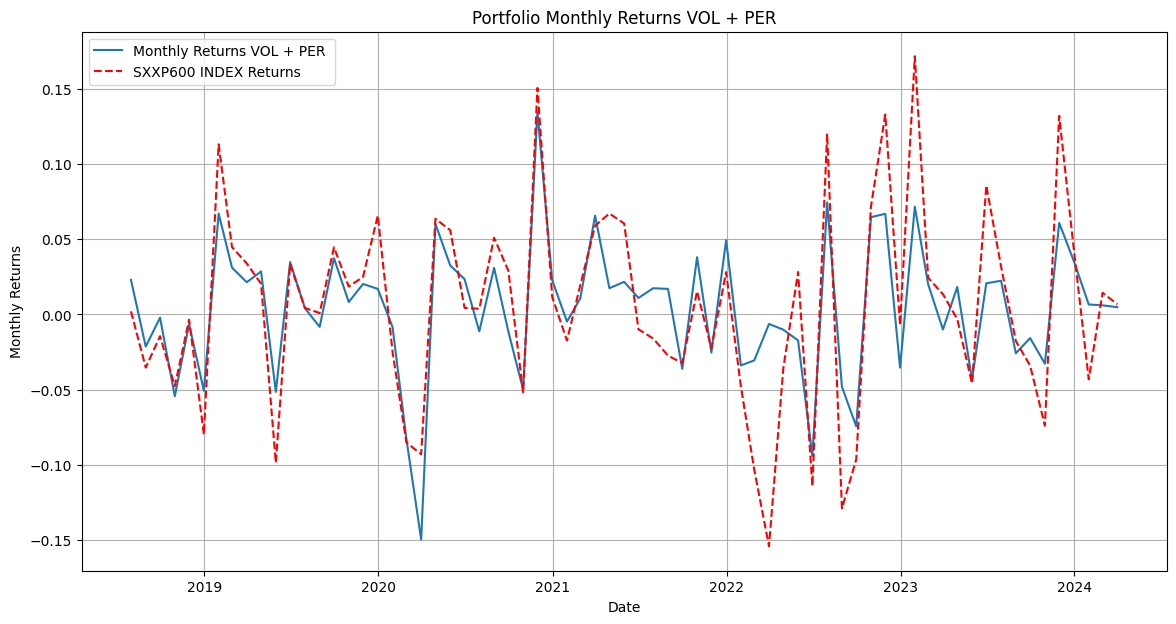

In [2]:
#Graphique Vol + PER
df.reset_index(inplace=True)
dates = df.iloc[18:18 + len(ptf_returns), 0]
plt.figure(figsize=(14, 7))
plt.plot(dates, ptf_returns, label='Monthly Returns VOL + PER ')
plt.plot(dates, df.iloc[18:, -2] .values, label='SXXP600 INDEX Returns ', linestyle='--', color='red')
plt.title('Portfolio Monthly Returns VOL + PER')
plt.xlabel('Date')
plt.ylabel('Monthly Returns')
plt.grid(True)
plt.legend()
plt.show()

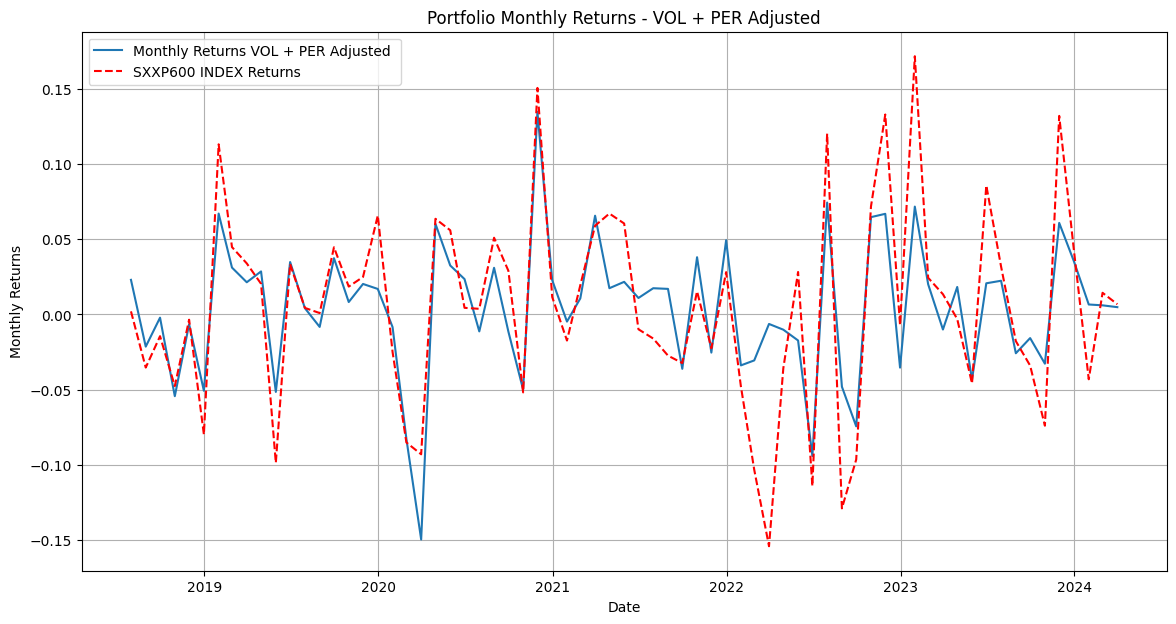

In [14]:
#Rendement Vol + Strat
df.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
plt.plot(dates, ptf_returns2, label='Monthly Returns VOL + PER Adjusted ')
plt.plot(dates, df.iloc[18:, -2] .values, label='SXXP600 INDEX Returns ', linestyle='--', color='red')
plt.title('Portfolio Monthly Returns - VOL + PER Adjusted')
plt.xlabel('Date')
plt.ylabel('Monthly Returns')
plt.grid(True)
plt.legend()
plt.show()

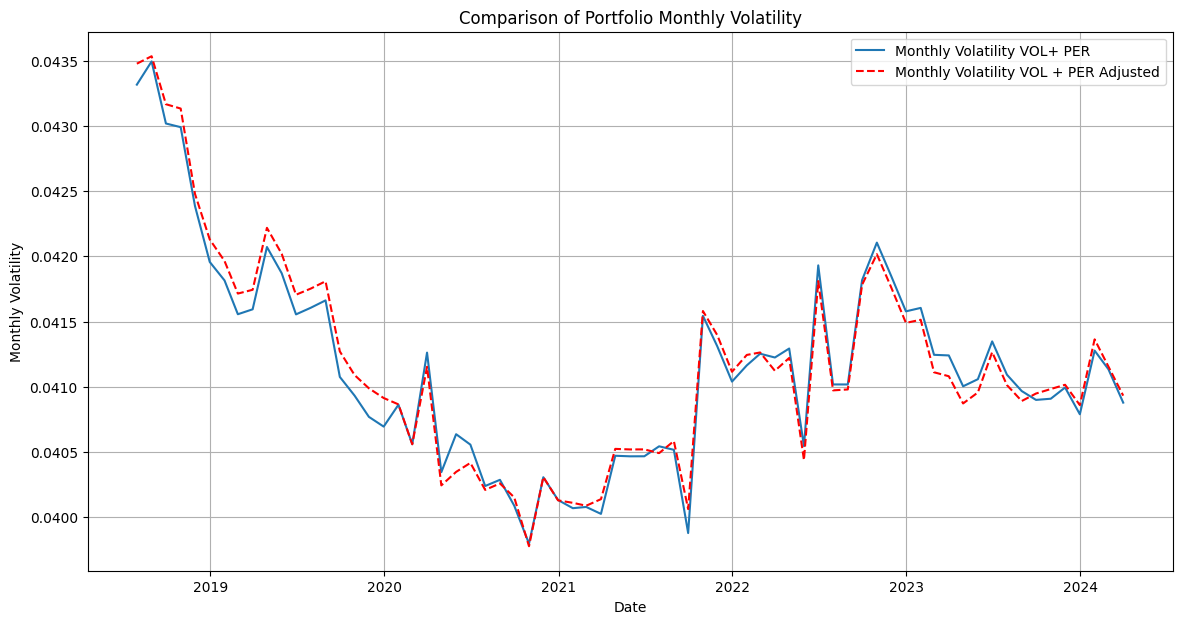

In [40]:
# Volatility
plt.figure(figsize=(14, 7))
 #plt.plot(dates, ptf_vol, label='Monthly Volatility')
plt.plot(dates, ptf_vol, label='Monthly Volatility VOL+ PER')
plt.plot(dates, ptf_vol2, label='Monthly Volatility VOL + PER Adjusted', linestyle='--', color='red')
plt.title('Comparison of Portfolio Monthly Volatility')
plt.xlabel('Date')
plt.ylabel('Monthly Volatility')
plt.grid(True)
plt.legend()
plt.show()

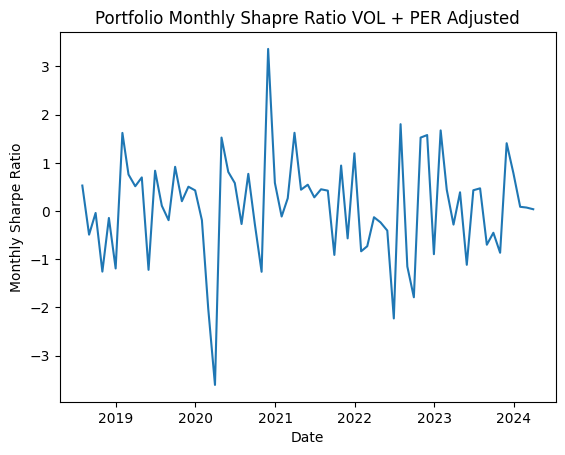

In [13]:
plt.plot(dates, ptf_sharpe_ratio2, label='Monthly Sharpe Ratio')
plt.title('Portfolio Monthly Shapre Ratio VOL + PER Adjusted')
plt.xlabel('Date')
plt.ylabel('Monthly Sharpe Ratio')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                     rf   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     6021.
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           2.42e-67
Time:                        08:53:58   Log-Likelihood:                 269.02
No. Observations:                  69   AIC:                            -534.0
Df Residuals:                      67   BIC:                            -529.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -1.777      0.0

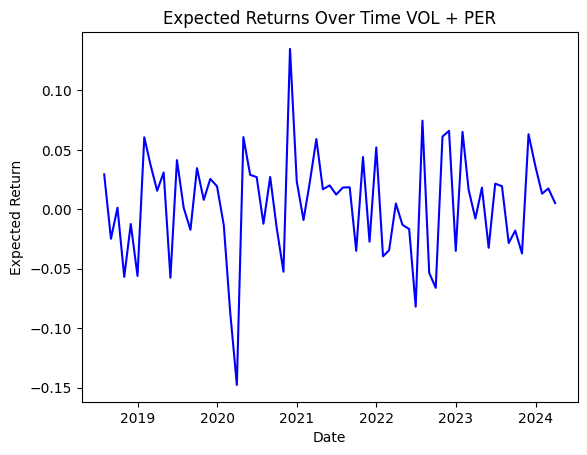

-0.001064760654621365


In [76]:
#CAPM
rm = df_return.iloc[1:, -1]
rf = monthly_close.iloc[1:, -1]
ptf_returns = np.array(ptf_returns)
excess_rm = rm - rf
excess_ptf_returns = np.array(ptf_returns) - rf.iloc[18:]
#beta_ptf, alpha_ptf = np.polyfit(excess_rm.iloc[18:], excess_ptf_returns, 1)
#expected_ptf = beta_ptf * excess_rm + alpha_ptf

x_add_constant = sm.add_constant(excess_rm)
x_reg=x_add_constant.iloc[18:]
regression = sm.OLS(excess_ptf_returns, x_reg)

results = regression.fit()
print(results.summary())
alpha = results.params.iloc[0]
beta = results.params.iloc[1]
tstat=results.tvalues.iloc[0]
p_val=results.pvalues.iloc[0]

 #calculer CAPM expected return
expected_return = rf+ alpha + beta * excess_rm.iloc[18:]

plt.plot(expected_excess_return.index, expected_excess_return, label='Expected Returns', color='blue')
plt.title('Expected Returns Over Time VOL + PER')
plt.xlabel('Date')
plt.ylabel('Expected Return')
plt.show()

print(alpha)

In [11]:
#Tracking error
return_differences = ptf_returns - df.iloc[18:18 + len(ptf_returns), -2].values
return_differences2 = ptf_returns2 - df.iloc[18:18 + len(ptf_returns2), -2].values

tracking_error = np.std(return_differences)
tracking_error2 = np.std(return_differences2)

tracking_error_year_5 = np.std(return_differences2[55:67])
tracking_error_year_4 = np.std(return_differences2[42:54])
tracking_error_year_3 = np.std(return_differences2[29:41])
tracking_error_year_2 = np.std(return_differences2[16:28])
tracking_error_year_1 = np.std(return_differences2[3:15])

print(tracking_error_year_1)
print(tracking_error_year_2)
print(tracking_error_year_3)
print(tracking_error_year_4)
print(tracking_error_year_5)
print(tracking_error)
print(tracking_error2)

0.021892505884772078
0.023328695548711132
0.02627156870884648
0.05925126723321107
0.035201564977684535
0.03707631570794829
0.037146222303996855


In [17]:
def calculate_annual_information_ratio(returns, benchmark_returns, start_index, end_index):

    period_returns = returns[start_index:end_index]
    period_benchmark_returns = benchmark_returns[start_index:end_index]

    excess_returns = period_returns - period_benchmark_returns

    average_excess_return = np.mean(excess_returns)

    tracking_error = np.std(excess_returns)

    IR = average_excess_return / tracking_error if tracking_error else 0

    return IR

benchmark_returns = df.iloc[18:18 + len(ptf_returns2), -2].values

IR_year_5 = calculate_annual_information_ratio(ptf_returns2, benchmark_returns, 55, 67)
IR_year_4 = calculate_annual_information_ratio(ptf_returns2, benchmark_returns, 42, 54)
IR_year_3 = calculate_annual_information_ratio(ptf_returns2, benchmark_returns, 29, 41)
IR_year_2 = calculate_annual_information_ratio(ptf_returns2, benchmark_returns, 16, 28)
IR_year_1 = calculate_annual_information_ratio(ptf_returns2, benchmark_returns, 3, 15)

print(f"Information Ratio for Year 1: {IR_year_1:.4f}")
print(f"Information Ratio for Year 2: {IR_year_2:.4f}")
print(f"Information Ratio for Year 3: {IR_year_3:.4f}")
print(f"Information Ratio for Year 4: {IR_year_4:.4f}")
print(f"Information Ratio for Year 5: {IR_year_5:.4f}")


Information Ratio for Year 1: -0.0443
Information Ratio for Year 2: -0.6138
Information Ratio for Year 3: 0.1535
Information Ratio for Year 4: 0.2683
Information Ratio for Year 5: -0.1266


In [25]:
def calculate_overall_information_ratio(returns, benchmark_returns):

    excess_returns = returns - benchmark_returns

    average_excess_return = np.mean(excess_returns)

    tracking_error = np.std(excess_returns)

    IR = average_excess_return / tracking_error if tracking_error else 0

    return IR
 
benchmark_returns = df.iloc[18:18 + len(ptf_returns2), -2].values  
overall_IR = calculate_overall_information_ratio(ptf_returns2, benchmark_returns)

print(f"Overall Information Ratio: {overall_IR:.4f}")

Overall Information Ratio: -0.0275


In [21]:
annualized_sharpe_ratio = np.mean(ptf_sharpe_ratio) * np.sqrt(12)
annualized_sharpe_ratio

0.3021940934106824

In [22]:
annualized_sharpe_ratio2 = np.mean(ptf_sharpe_ratio2) * np.sqrt(12)
annualized_sharpe_ratio2

0.3050080973954658

In [73]:
min_return = np.min(ptf_returns2)
max_return = np.max(ptf_returns2)
average_return = np.mean(ptf_returns2)

print("Minimum Return:", min_return)
print("Maximum Return:", max_return)
print("Average Return:", average_return)

Minimum Return: -0.14888337992369632
Maximum Return: 0.13522453302576887
Average Return: 0.003919668822418547


In [68]:
min_return_index = np.argmax(ptf_sharpe_ratio2)
min_return_date = dates.iloc[min_return_index]
print("Date of Minimum Return:", min_return_date)

Date of Minimum Return: 2020-11-30 00:00:00


Portfolio Weights at Date of Minimum Return: [[0.06136895 0.03745512 0.03646585 0.04154217 0.0408605  0.05112028
  0.04422951 0.03861408 0.0390725  0.04401603 0.07485434 0.07521423
  0.03347184 0.04221456 0.06051397 0.04002722 0.05580042 0.0513978
  0.05218915 0.03470798 0.04486349]]


In [70]:
min_return2 = np.min(ptf_returns2)
max_return2 = np.max(ptf_returns2)
average_return2 = np.mean(ptf_returns2)

print("Minimum Return:", min_return2)
print("Maximum Return:", max_return2)
print("Average Return:", average_return2)

Minimum Return: -0.14972528086282935
Maximum Return: 0.13487257498328983
Average Return: 0.0038763683967056213


In [65]:
min_return_index = np.argmin(ptf_sharpe_ratio)
min_return_date = dates.iloc[min_return_index]
print("Date of Minimum Return:", min_return_date)

Date of Minimum Return: 2020-03-31 00:00:00


In [44]:
expected_excess_return

Date
2018-07-31    0.032937
2018-08-31   -0.021329
2018-09-30    0.004797
2018-10-31   -0.053452
2018-11-30   -0.008894
                ...   
2023-11-30    0.024238
2023-12-31   -0.002223
2024-01-31   -0.025825
2024-02-29   -0.021336
2024-03-31   -0.033791
Freq: M, Length: 69, dtype: float64

0.9889466439725861